<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Segment_Anything_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Segment Anything Model with 🤗Transformers**

## Introduction

Large language models (LLMs) make it easy for the end users to apply them to various
applications through "prompting". For example if we wanted an LLM to predict the
sentiment of the following sentence -- "That movie was amazing, I thoroughly enjoyed it"
-- we'd do prompt the LLM with something like:

> What's the sentiment of the following sentence: "That movie was amazing, I thoroughly
enjoyed it"?

In return, the LLM would return sentiment token.

But when it comes to visual recognition tasks, how can we engineer "visual" cues to
prompt foundation vision models? For example, we could have an input image and prompt the
model with bounding box on that image and ask it to perform segmentation. The bounding
box would serve as our visual prompt here.

In the [Segment Anything Model](https://segment-anything.com/) (dubbed as SAM),
researchers from Meta extended the space of language prompting to visual prompting. SAM
is capable of performing zero-shot segmentation with a prompt input, inspired by large
language models. The prompt here can be a set of foreground/background points, free text,
a box or a mask. There are many downstream segmentation tasks, including semantic
segmentation and edge detection. The goal of SAM is to enable all of these downstream
segmentation tasks through prompting.

In this example, we'll learn how to use the SAM model from 🤗 Transformers for performing
inference and fine-tuning.





## Installation

In [1]:
!!pip install -q git+https://github.com/huggingface/transformers

['  Installing build dependencies ... \x1b[?25l\x1b[?25hdone',
 '  Getting requirements to build wheel ... \x1b[?25l\x1b[?25hdone',
 '  Preparing metadata (pyproject.toml) ... \x1b[?25l\x1b[?25hdone',
 '  Building wheel for transformers (pyproject.toml) ... \x1b[?25l\x1b[?25hdone']

In [2]:
import os
import glob
import requests
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from transformers import TFSamModel, SamProcessor
from tensorflow.python.ops.numpy_ops import np_config

## SAM in a few words

SAM has the following components:

|
![](https://imgur.com/oLfdwuB)
|:--:|
| Image taken from the official
[SAM blog post](https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/) |
|




The image encoder is responsible for computing image embeddings. When interacting with
SAM, we compute the image embedding one time (as the image encoder is heavy) and then
reuse it with different prompts mentioned above (points, bounding boxes, masks).

Points and boxes (so-called sparse prompts) go through a lightweight prompt encoder,
while masks (dense prompts) go through a convolutional layer. We couple the image
embedding extracted from the image encoder and the prompt embedding and both go to a
lightweight mask decoder. The decoder is responsible for predicting the mask.

| ![](https://i.imgur.com/QQ9Ts5T.png) |
|:--:|
| Figure taken from the [SAM paper](https://arxiv.org/abs/2304.02643) |



SAM was pre-trained to predict a _valid_ mask for any acceptable prompt. This requirement
allows SAM to output a valid mask even when the prompt is ambiguous to understand -- this
makes SAM ambiguity-aware. Moreover, SAM predicts multiple masks for a single prompt.

We highly encourage you to check out the [SAM paper](https://arxiv.org/abs/2304.02643)
and the
[blog post](https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/)
to learn more about the additional details of SAM and the dataset used to pre-trained it.



## Running inference with SAM

There are three checkpoints for SAM:

* [sam-vit-base](https://huggingface.co/facebook/sam-vit-base)
* [sam-vit-large](https://huggingface.co/facebook/sam-vit-large)
* [sam-vit-huge](https://huggingface.co/facebook/sam-vit-huge).

We load `sam-vit-base` in
[`TFSamModel`](https://huggingface.co/docs/transformers/main/model_doc/sam#transformers.TFSamModel).
We also need `SamProcessor`for the associated checkpoint.

In [3]:
model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/375M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Next, we write some utility functions for visualization. Most of these functions are
taken from
[this notebook](https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb).

In [4]:
np_config.enable_numpy_behavior()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

We will segment a car image using a point prompt. Make sure to set `return_tensors` to
`tf` when calling the processor.

Let's load an image of a car and segment it.

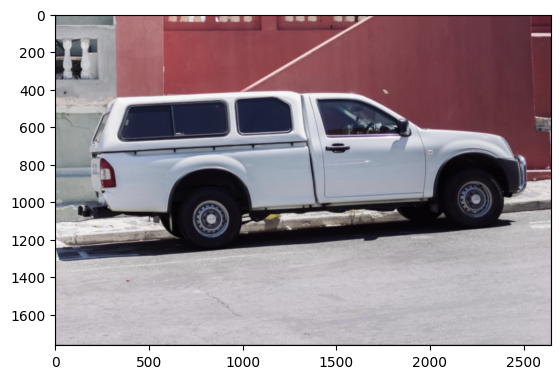

In [5]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
plt.imshow(raw_image)
plt.show()

Let's now define a set of points we will use as the prompt.

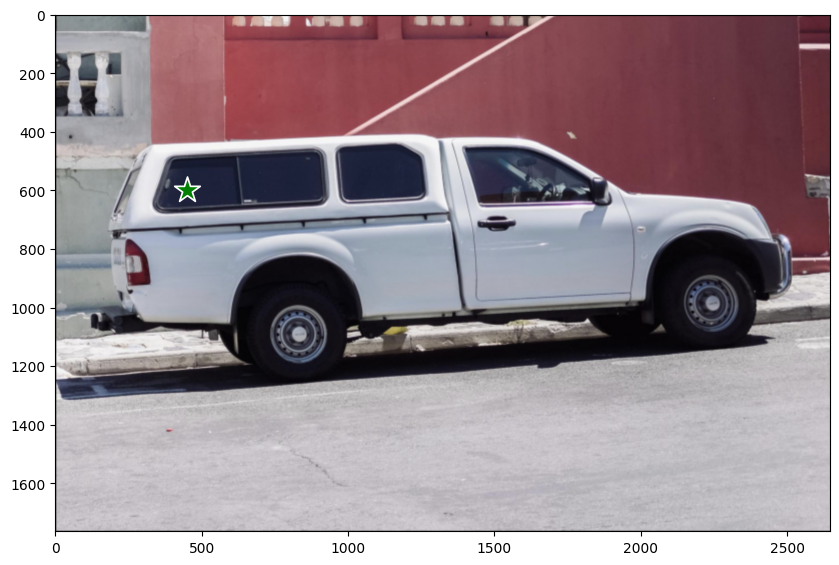

In [6]:
input_points = [[[450, 600]]]

# Visualize a single point.
show_points_on_image(raw_image, input_points[0])

And segment:

In [7]:
# Preprocess the input image.
inputs = processor(raw_image, input_points=input_points, return_tensors="tf")

# Predict for segmentation with the prompt.
outputs = model(**inputs)

`outputs` has got two attributes of our interest:

* `outputs.pred_masks`: which denotes the predicted masks.
* `outputs.iou_scores`: which denotes the IoU scores associated with the masks.



Let's post-process the masks and visualize them with their IoU scores:

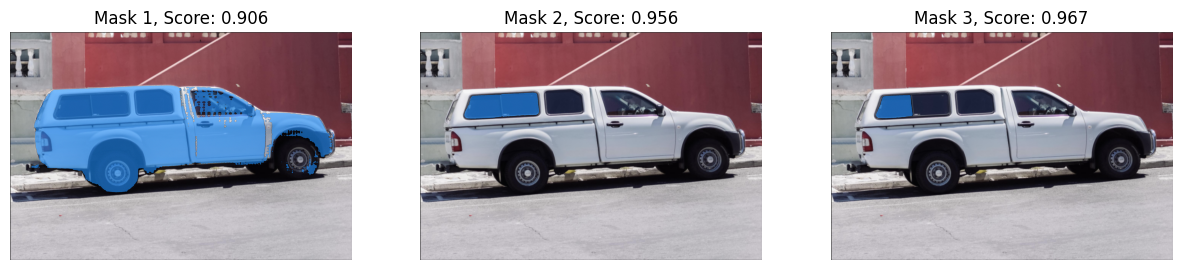

In [8]:
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors="tf")

show_masks_on_image(raw_image, masks, outputs.iou_scores)

And there we go!

As can be noticed, all the masks are _valid_ masks for the point prompt we provided.

SAM is flexible enough to support different visual prompts and we encourage you to check
out [this
notebook](https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipy
nb) to know more about them!



## Fine-tuning

We'll use [this dataset](https://huggingface.co/datasets/nielsr/breast-cancer) consisting
of breast cancer scans. In the medical imaging domain, being able to segment the cells
containing malignancy is an important task.

### Data preparation

Let's first get the dataset.

In [9]:
remote_path = "https://hf.co/datasets/sayakpaul/sample-datasets/resolve/main/breast-cancer-dataset.tar.gz"
dataset_path = keras.utils.get_file(
    "breast-cancer-dataset.tar.gz", remote_path, untar=True
)

8652800/8652800 [==============================] - 0s 0us/step


Let's now visualize a sample from the dataset.

*(The `show_mask()` utility is taken from
[this notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb))*

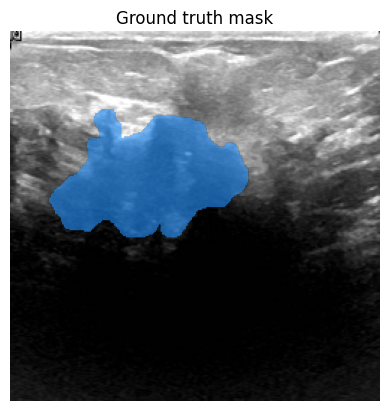

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([256, 256], dtype=int32)>

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# Load all the image and label paths.
image_paths = sorted(glob.glob(os.path.join(dataset_path, "images/*.png")))
label_paths = sorted(glob.glob(os.path.join(dataset_path, "labels/*.png")))

# Load the image and label.
idx = 15
image = Image.open(image_paths[idx])
label = Image.open(label_paths[idx])
image = np.array(image)
ground_truth_seg = np.array(label)

# Display.
fig, axes = plt.subplots()
axes.imshow(image)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")
plt.show()

tf.shape(ground_truth_seg)

### Preparing `tf.data.Dataset`

We now write a generator class to prepare the images and the segmentation masks using the
`processor` utilized above. We will leverage this generator class to create a
`tf.data.Dataset` object for our training set by using
`tf.data.Dataset.from_generator()`. Utilities of this class have been adapted from
[this notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb).

The generator is responsible for yielding the preprocessed images and the segmentation
masks, and some other metadata needed by the SAM model.

In [11]:
class Generator:
    """Generator class for processing the images and the masks for SAM fine-tuning."""

    def __init__(self, dataset_path, processor):
        self.dataset_path = dataset_path
        self.image_paths = sorted(
            glob.glob(os.path.join(self.dataset_path, "images/*.png"))
        )
        self.label_paths = sorted(
            glob.glob(os.path.join(self.dataset_path, "labels/*.png"))
        )
        self.processor = processor

    def __call__(self):
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path))
            ground_truth_mask = np.array(Image.open(label_path))

            # get bounding box prompt
            prompt = self.get_bounding_box(ground_truth_mask)

            # prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")

            # remove batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # add ground truth segmentation
            inputs["ground_truth_mask"] = ground_truth_mask

            yield inputs

    def get_bounding_box(self, ground_truth_map):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        return bbox

`get_bounding_box()` is responsible for turning the ground-truth segmentation maps into
bounding boxes. These bounding boxes are fed to SAM as prompts (along with the original
images) during fine-tuning and SAM is then trained to predict valid masks.

The advantage of this first creating a generator and then using it to create a
`tf.data.Dataset` is the flexbility. Sometimes, we may need to use utitlities from other
libraries ([`albumentations`](https://albumentations.ai/), for example) which may not
come in native TensorFlow implementations. By using this workflow, we can easily
accommodate such use case.

But the non-TF counterparts might introduce performance bottlenecks, though. However, for
our example, it should work just fine.

Now, we prepare the `tf.data.Dataset` from our training set.

In [12]:
# Define the output signature of the generator class.
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}

# Prepare the dataset object.
train_dataset_gen = Generator(dataset_path, processor)
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)

Next, we configure the dataset for performance.

In [13]:
auto = tf.data.AUTOTUNE
batch_size = 2
shuffle_buffer = 4

train_ds = (
    train_ds.cache()
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)

Take a single batch of data and inspect the shapes of the elements present inside of it.

In [14]:
sample = next(iter(train_ds))
for k in sample:
    print(k, sample[k].shape, sample[k].dtype, isinstance(sample[k], tf.Tensor))

pixel_values (2, 3, 1024, 1024) <dtype: 'float32'> True
original_sizes (2, 2) <dtype: 'int64'> True
reshaped_input_sizes (2, 2) <dtype: 'int64'> True
input_boxes (2, 1, 4) <dtype: 'float64'> True
ground_truth_mask (2, 256, 256) <dtype: 'int32'> True


### Training



We will now write DICE loss. This implementation is based on
[MONAI DICE loss](https://docs.monai.io/en/stable/_modules/monai/losses/dice.html#DiceLoss).

In [15]:
def dice_loss(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    if batch_size > 1:
        # reducing spatial dimensions and batch
        reduce_axis = [0] + reduce_axis
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)
    denominator = ground_o + pred_o
    # calculate DICE coefficient
    loss = 1.0 - (2.0 * intersection + 1e-5) / (denominator + 1e-5)
    loss = tf.reduce_mean(loss)

    return loss

## Fine-tuning SAM

We will now fine-tune SAM's decoder part. We will freeze the vision encoder and prompt
encoder layers.

In [16]:
# initialize SAM model and optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-base")
optimizer = keras.optimizers.Adam(1e-5)

for layer in sam.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False


@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # pass inputs to SAM model
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=True)

        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # calculate loss over predicted and ground truth masks
        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # update trainable variables
        trainable_vars = sam.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))

        return loss

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


We can now run the training for three epochs. We might have a warning about gradients
not existing on IoU prediction head of mask decoder, we can safely ignore that.

In [17]:
# run training
for epoch in range(3):
    for inputs in train_ds:
        loss = train_step(inputs)
    print(f"Epoch {epoch + 1}: Loss = {loss}")

Epoch 1: Loss = 0.06592410802841187
Epoch 2: Loss = 0.06489086151123047
Epoch 3: Loss = 0.0613253116607666


### Serialize the model



We serialized the model and pushed for you below. `push_to_hub` method serializes model,
generates a model card and pushes it to Hugging Face Hub, so that other people can load
the model using `from_pretrained` method to infer or further fine-tune. We also need to
push the same preprocessor in the repository. Find the model and the preprocessor
[here](https://huggingface.co/merve/sam-finetuned).


 `sam.push_to_hub("merve/sam-finetuned")`
 `processor.push_to_hub("merve/sam-finetuned")`


We can now infer with the model.

In [18]:
# Load another image for inference.
idx = 20
raw_image_inference = Image.open(image_paths[idx])

# process the image and infer
preprocessed_img = processor(raw_image_inference)
outputs = sam(preprocessed_img)

Lastly, we can visualize the results.

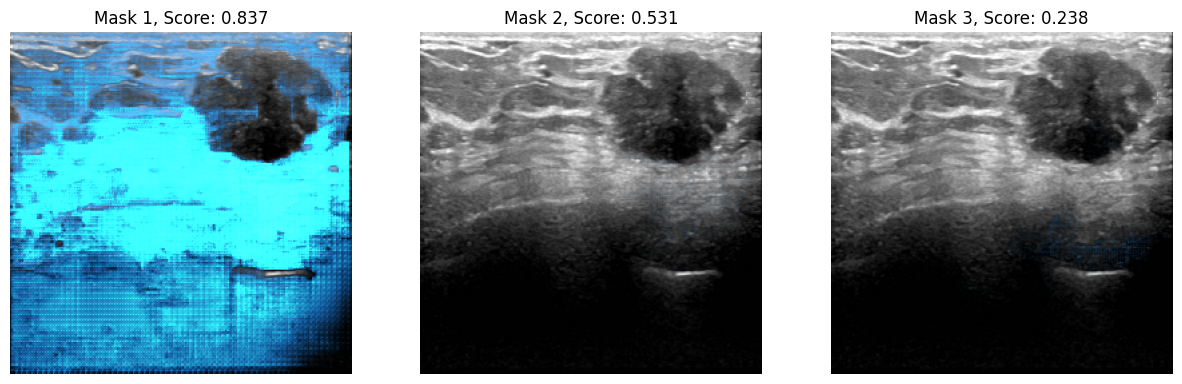

In [19]:
infer_masks = outputs["pred_masks"]
iou_scores = outputs["iou_scores"]
show_masks_on_image(raw_image_inference, masks=infer_masks, scores=iou_scores)